In [269]:
import shap
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [270]:
with open("../T23_shap_ml/S01_shap_calc.pkl", "rb") as f:
    data = pickle.load(f)
    shaps_ml = data["shaps"]
    infos_ml = data["infos"]

In [271]:
pd.DataFrame.from_dict(infos_ml)

,model,model_params,test_size,random_state
0,DTR,"{'criterion': 'squared_error', 'splitter': 'ra...",0.3,4
1,EN,"{'alpha': 0.03388469103413104, 'l1_ratio': 0.4...",0.3,5
2,GBR,"{'n_estimators': 134, 'learning_rate': 0.02748...",0.3,4
3,KNR,"{'n_neighbors': 36, 'weights': 'distance', 'al...",0.3,5
4,RFR,"{'n_estimators': 60, 'max_depth': 5, 'min_samp...",0.3,5
5,SVR,"{'kernel': 'linear', 'C': 0.012708183589980318...",0.3,5
6,XGBR,"{'n_estimators': 229, 'max_depth': 8, 'learnin...",0.3,5


In [272]:
shap_values_list = []

In [273]:
idxs = [2, 4, 6]
for idx in idxs:
    shap_values = shaps_ml[idx]["shap_values"]
    model = shaps_ml[idx]["model"]
    shap_values_list.append(shap_values)
    print(f"Model: {model}")

Model: GBR
Model: RFR
Model: XGBR


In [274]:
with open("../T24_shap_tabPFN/S02_shap_values.pkl", "rb") as f:
    data = pickle.load(f)
    shaps_tabPFN = data["shaps"]


shap_values_list.append(shaps_tabPFN)

In [275]:
# Combine SHAP values
feature_names = shap_values_list[0].feature_names

# Combine values
combined_shape_values = np.vstack([sv.values for sv in shap_values_list])
combined_shape_values.shape

# Combine base values
combined_base_values = np.concatenate([sv.base_values for sv in shap_values_list])
combined_base_values.shape

# Combine data (feature values)
combined_data = np.vstack([sv.data for sv in shap_values_list])
combined_data.shape

(1176, 20)

In [276]:
shap_values = shap.Explanation(
    values=combined_shape_values,
    base_values=combined_base_values,
    data=combined_data,
    feature_names=shap_values_list[0].feature_names,
)

In [277]:
sns.set_theme(style="whitegrid", context="talk")

,shap_value,feature_value,feature_value_rounded,feature_value_text
0,0.553972,-0.513150,-0.5,Loc-3
1,0.344752,-0.009538,-0.0,Loc-4
2,-0.632888,0.997687,1.0,Loc-6
3,0.382681,-0.513150,-0.5,Loc-3
4,0.127397,0.494074,0.5,Loc-5
...,...,...,...,...
1171,-0.730626,1.012931,1.0,Loc-6
1172,0.273104,0.020672,0.0,Loc-4
1173,0.392642,-0.971587,-1.0,Loc-2
1174,0.231385,-1.467716,-1.5,Loc-1


feature_value_text
Loc-1    0.374246
Loc-2    0.383495
Loc-3    0.383740
Loc-4    0.388475
Loc-5    0.055694
Loc-6   -0.678673
Loc-7   -0.746991
Name: shap_value, dtype: float64

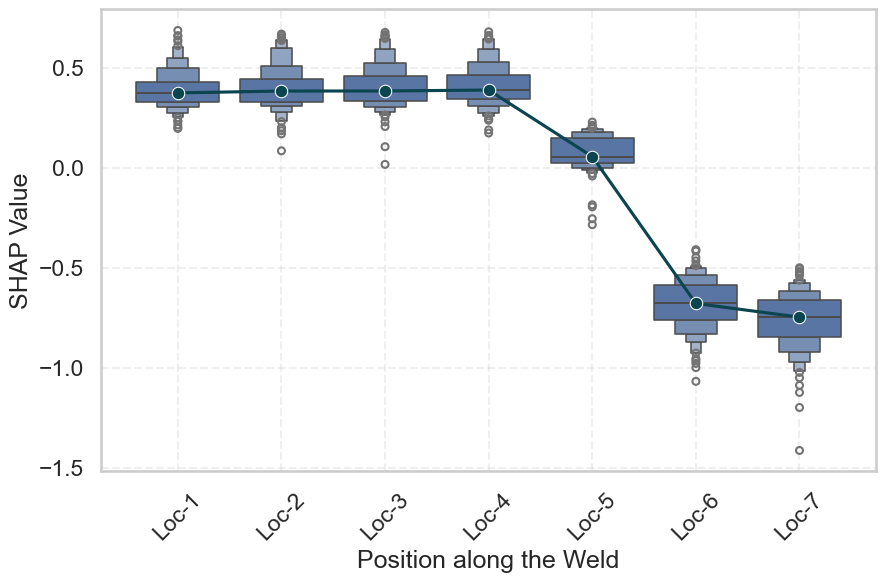

In [278]:
feature_name = "position"
idx = shap_values.feature_names.index(feature_name)
df_plot = pd.DataFrame(
    {
        "shap_value": shap_values.values[:, idx],
        "feature_value": shap_values.data[:, idx],
    }
)

df_plot["feature_value_rounded"] = df_plot["feature_value"].round(1)

val_list = df_plot.sort_values(by="feature_value_rounded", ascending=True)[
    "feature_value_rounded"
].unique()
map_dict = {v: f"Loc-{i + 1}" for i, v in enumerate(val_list)}

df_plot["feature_value_text"] = df_plot["feature_value_rounded"].map(map_dict)

sort = [map_dict[v] for v in val_list]

display(df_plot)

fig, ax = plt.subplots(figsize=(10, 6))
sns.boxenplot(data=df_plot, x="feature_value_text", y="shap_value", order=sort)
plt.xticks(rotation=45)
plt.xlabel("Position along the Weld")
plt.ylabel("SHAP Value")

# Linear trend of mean
df_plot_grouped = (
    df_plot.groupby("feature_value_text")["shap_value"].median().reindex(sort)
)
display(df_plot_grouped)
sns.lineplot(
    x=df_plot_grouped.index, y=df_plot_grouped.values, marker="o", color="#0A4550"
)
plt.grid(True, which="major", linestyle="--", alpha=0.3)
plt.xticks(rotation=45)
plt.savefig("shap_position.png", dpi=300, bbox_inches="tight")

[-1. -0.  1.]


,shap_value,feature_value,feature_value_rounded,feature_value_text
0,-0.073703,1.255605,1.0,R3
1,-0.137339,1.255605,1.0,R3
2,0.153245,-1.181745,-1.0,R1
3,-0.115857,1.255605,1.0,R3
4,0.198171,-1.181745,-1.0,R1
...,...,...,...,...
1171,-0.225549,-0.050953,-0.0,R2
1172,-0.417073,1.171912,1.0,R3
1173,-0.224065,-0.050953,-0.0,R2
1174,-0.247422,-0.050953,-0.0,R2


feature_value_text
R1    0.096147
R2   -0.047724
R3   -0.057210
Name: shap_value, dtype: float64

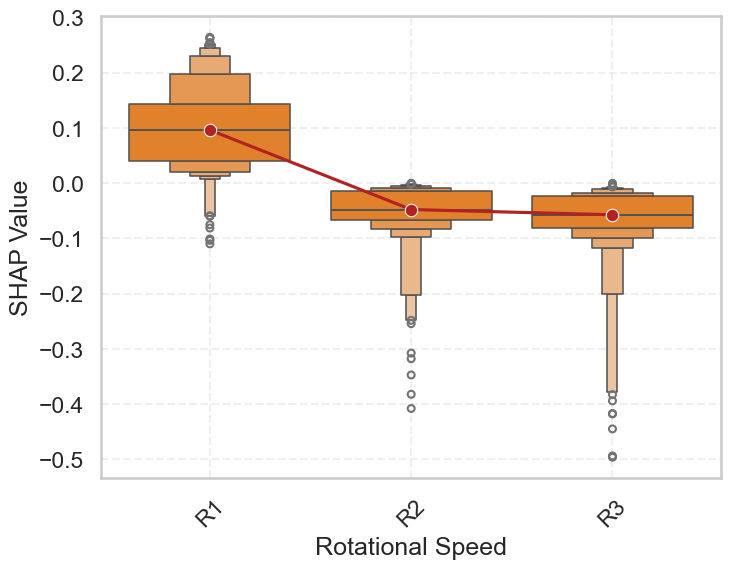

In [279]:
feature_name = "R"
idx = shap_values.feature_names.index(feature_name)
df_plot = pd.DataFrame(
    {
        "shap_value": shap_values.values[:, idx],
        "feature_value": shap_values.data[:, idx],
    }
)

df_plot["feature_value_rounded"] = df_plot["feature_value"].round(0)

val_list = df_plot.sort_values(by="feature_value_rounded", ascending=True)[
    "feature_value_rounded"
].unique()
print(val_list)
map_dict = {-1: "R1", 0: "R2", 1: "R3"}

df_plot["feature_value_text"] = df_plot["feature_value_rounded"].map(map_dict)

sort = [map_dict[v] for v in val_list]

display(df_plot)

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxenplot(
    data=df_plot, x="feature_value_text", y="shap_value", order=sort, color="tab:orange"
)
plt.xticks(rotation=45)
plt.xlabel("Rotational Speed")
plt.ylabel("SHAP Value")

# Linear trend of mean
df_plot_grouped = (
    df_plot.groupby("feature_value_text")["shap_value"].median().reindex(sort)
)
display(df_plot_grouped)
sns.lineplot(
    x=df_plot_grouped.index, y=df_plot_grouped.values, marker="o", color="#B22222"
)
plt.grid(True, which="major", linestyle="--", alpha=0.3)
plt.xticks(rotation=45)
plt.savefig("shap_R.png", dpi=300, bbox_inches="tight")

[-1.  0.  1.]


,shap_value,feature_value,feature_value_rounded,feature_value_text
0,0.089141,1.251840,1.0,W3
1,-0.029771,0.023268,0.0,W2
2,-0.048380,-1.205303,-1.0,W1
3,0.113328,1.251840,1.0,W3
4,-0.009884,0.023268,0.0,W2
...,...,...,...,...
1171,0.074641,0.036930,0.0,W2
1172,0.098936,1.255605,1.0,W3
1173,0.135923,1.255605,1.0,W3
1174,0.044635,-1.181745,-1.0,W1


feature_value_text
W1   -0.014927
W2   -0.002909
W3    0.020997
Name: shap_value, dtype: float64

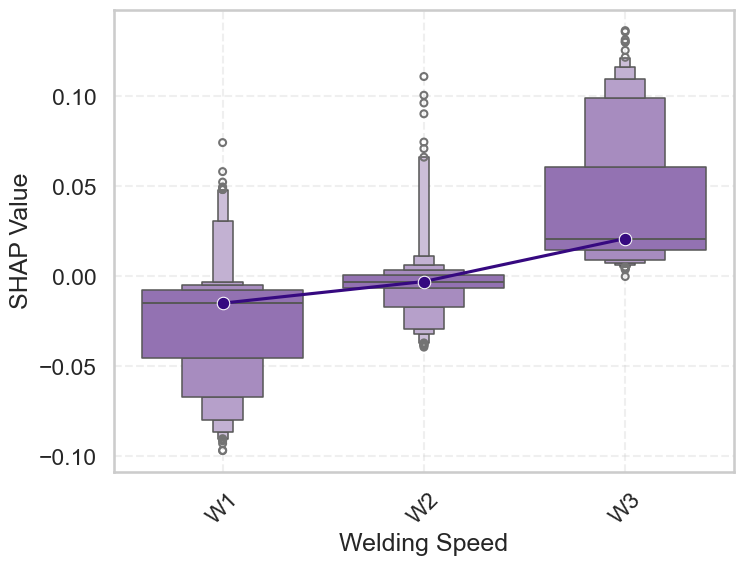

In [280]:
feature_name = "W"
idx = shap_values.feature_names.index(feature_name)
df_plot = pd.DataFrame(
    {
        "shap_value": shap_values.values[:, idx],
        "feature_value": shap_values.data[:, idx],
    }
)

df_plot["feature_value_rounded"] = df_plot["feature_value"].round(0)

val_list = df_plot.sort_values(by="feature_value_rounded", ascending=True)[
    "feature_value_rounded"
].unique()
print(val_list)
map_dict = {-1: "W1", 0: "W2", 1: "W3"}

df_plot["feature_value_text"] = df_plot["feature_value_rounded"].map(map_dict)

sort = [map_dict[v] for v in val_list]

display(df_plot)
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxenplot(
    data=df_plot, x="feature_value_text", y="shap_value", order=sort, color="tab:purple"
)
plt.xticks(rotation=45)
plt.xlabel("Welding Speed")
plt.ylabel("SHAP Value")

# Linear trend of mean
df_plot_grouped = (
    df_plot.groupby("feature_value_text")["shap_value"].median().reindex(sort)
)
display(df_plot_grouped)
sns.lineplot(
    x=df_plot_grouped.index, y=df_plot_grouped.values, marker="o", color="#360980"
)
plt.grid(True, which="major", linestyle="--", alpha=0.3)
plt.xticks(rotation=45)
plt.savefig("shap_W.png", dpi=300, bbox_inches="tight")